In [1]:
user_agent_headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36"}

In [21]:
import pandas as pd
import yfinance as yf

In [2]:
import requests
import bs4

In [13]:
def getMySustainability(ticker):
    webData = requests.get("https://finance.yahoo.com/quote/" + ticker + "/sustainability", headers=user_agent_headers).text
    soup = bs4.BeautifulSoup(webData, "html.parser")
    
    esgScore = soup.find("div", {"class" : "Fz(36px) Fw(600) D(ib) Mend(5px)"}).text
    elements = [ii.text for ii in soup.find_all("div", {"class" : "D(ib) Fz(23px) smartphone_Fz(22px) Fw(600)"})]
    controversyScore = soup.find("div", {"class" : "D(ib) Fz(36px) Fw(500)"}).text
    
    return pd.DataFrame({"totalEsg" : esgScore,
             "E Score" : elements[0],
             "S Score" : elements[1],
             "G Score" : elements[2],
             "Controversy Score" : controversyScore}, index=[ticker])

### Performance by ESG Rating ###

In [6]:
wikiPg = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").text
tickerList = pd.read_html(wikiPg)[0]["Symbol"].tolist()
len(tickerList)

503

In [16]:
esgData = pd.DataFrame()
for ii in tickerList[:12]: ### truncated list!
    print(ii)
    try:
        objY = getMySustainability(ii)
        esgData = esgData.append(objY)
    except Exception as e:
        print(e)

MMM
AOS
ABT
ABBV
ACN
ATVI
ADM
ADBE
ADP
AES
AFL
A


In [18]:
esgData.sort_values("totalEsg", inplace=True)
esgData

,totalEsg,E Score,S Score,G Score,Controversy Score
ACN,10,0.3,4.6,4.8,2
ADBE,12,1.9,5.9,4.6,1
ADP,14,1.1,7.0,5.9,1
A,15,0.3,8.6,6.3,1
AFL,17,0.5,7.3,9.6,2
ATVI,19,0.2,12.5,6.3,4
AOS,25,7.3,11.9,6.3,0
ABT,25,3.0,13.6,8.4,3
ABBV,28,1.1,16.8,9.9,3
MMM,34,12.3,13.6,7.7,3


In [19]:
allTix = esgData.index.to_list()
esgData.shape

(12, 5)

In [22]:
dfPx = yf.download(" ".join(allTix), start="2015-01-01")["Adj Close"]

[*********************100%***********************]  12 of 12 completed


In [23]:
dfPx.fillna(method="ffill", inplace=True)
dfPx.fillna(method="bfill", inplace=True)

In [24]:
lstSer = []
for ii in range(5):
    tixList = allTix[2 * ii:2 * (ii + 1)] #allTix[90 * ii:90 * (ii + 1)]
    seriesX = dfPx[tixList].sum(axis=1)
    seriesX /= seriesX[0]
    lstSer.append(seriesX)

In [25]:
dfRes = pd.DataFrame(lstSer).T
dfRes.columns = ["Quintile {:d}".format(5 - ii) for ii in range(5)]
dfRes

,Quintile 5,Quintile 4,Quintile 3,Quintile 2,Quintile 1
Date,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,0.988890,0.992923,0.979121,0.993290,0.978457
2015-01-06,0.975517,0.982168,0.966245,0.983232,0.969539
2015-01-07,0.989958,0.992286,0.960653,0.990907,0.985322
2015-01-08,1.009918,1.017479,0.970124,1.013370,1.005227
...,...,...,...,...,...
2023-08-28,5.703347,3.498264,3.818157,2.775235,1.491197
2023-08-29,5.791764,3.517517,3.824813,2.810906,1.500741
2023-08-30,5.822532,3.529105,3.825272,2.826581,1.498429


<AxesSubplot:xlabel='Date'>

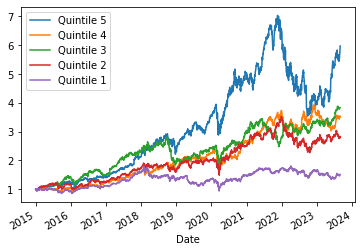

In [26]:
dfRes.plot()